In [2]:
import numpy as np
from models import *
from priors_new import *
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
model_prior = StandardNormal(latent_dim=1)
model_encoder = build_encoder(dim_x=100, h_dim=64, n_layers=2)
model_decoder = build_decoder(dim_x=100, latent_dim=1, h_dim=64, n_layers=2)
model = VariationalAutoencoder(encoder=model_encoder, enc_out_dim=64, decoder=model_decoder, prior=model_prior)

In [4]:
@torch.no_grad()
def generate_clustered_gauss_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,          # 1D latent space
    sigma_val: float = 0.5,       # observation noise std for Gaussian in feature space
    cluster_centers=None,         # if None, auto-generate
    cluster_spread: float = 0.2,  # smaller => tighter clusters in latent space
    seed: int = 42,
    device: str = "cpu",
):
    """
    Build a clean clusterable dataset with 1D latent space:
      z | c ~ N(center[c], cluster_spread^2) in R^latent_dim
      x | z ~ N(W z + b, sigma^2 I) in R^{n_features}
    Returns:
      X [N, D] (float), labels [N] (long), true Z [N, latent_dim], centers [K, latent_dim]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in latent space (R^{latent_dim})
    if cluster_centers is None:
        # Evenly spaced along the first latent axis; zeros elsewhere if latent_dim>1
        centers_1d = torch.linspace(-2, 2, n_clusters, device=device)
        centers = torch.zeros(n_clusters, latent_dim, device=device)
        centers[:, 0] = centers_1d
    else:
        centers = torch.as_tensor(cluster_centers, dtype=torch.float32, device=device)
        if centers.ndim == 1:
            centers = centers.unsqueeze(1)  # [K,1] if given as list of scalars
        assert centers.shape == (n_clusters, latent_dim), \
            f"centers must be shape ({n_clusters},{latent_dim})"

    # Cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]

    # Latent samples
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster centers

    # Linear map to feature space
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    mean_x = z @ W.T + b  # [N, D]

    # Gaussian observation noise (isotropic)
    if sigma_val <= 0:
        X = mean_x
    else:
        X = mean_x + sigma_val * torch.randn(mean_x.shape, device=mean_x.device, generator=g)

    return X, labels.to("cpu"), z.to("cpu"), centers.to("cpu"), W,b

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers, W,b = generate_clustered_gauss_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    sigma_val=0.5,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: cpu
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


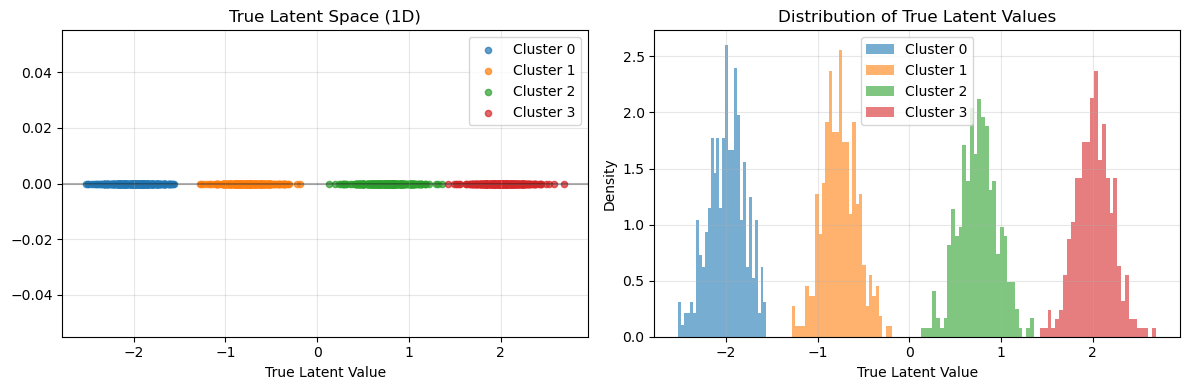

In [7]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [9]:
model.to(device)
model.prior.to(device)

StandardNormal()

In [10]:
model.train()
epochs, kl_warm = 500, 50
losses_history = []

print("Starting training...")
for ep in range(1, epochs+1):
    #kl_w = min(21.0, ep / kl_warm)
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        loss,_ = model.variational_inference_step(xb,optimizer=opt)
        losses={"loss":loss}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 20 == 0 or ep == epochs:
        #print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")
        print(f"[{ep:03d}] loss={tot/n:.3f}")

print("Training completed!")


Starting training...
[001] loss=6719.483
[020] loss=135.815
[040] loss=97.762
[060] loss=81.618
[080] loss=79.002
[100] loss=78.173
[120] loss=77.747
[140] loss=77.506
[160] loss=76.908
[180] loss=76.649
[200] loss=76.424
[220] loss=76.291
[240] loss=76.197
[260] loss=76.027
[280] loss=76.125
[300] loss=75.960
[320] loss=75.953
[340] loss=75.969
[360] loss=75.850
[380] loss=75.830
[400] loss=75.873
[420] loss=75.859
[440] loss=75.813
[460] loss=75.855
[480] loss=75.777
[500] loss=75.761
Training completed!


In [11]:
model.prior.to(device)

StandardNormal()

In [12]:
model.prior

StandardNormal()

In [13]:
model.eval()
with torch.no_grad():
    mu_q = model._define_variational_family(X.float().to(device)).mean

In [14]:
mu_q

tensor([[ 1.1507],
        [ 1.1962],
        [ 1.2525],
        ...,
        [-1.7938],
        [-1.6601],
        [-1.7592]])

In [15]:
y.shape

torch.Size([1200])

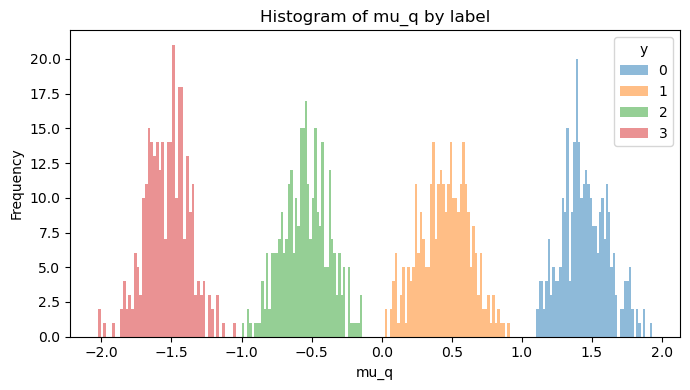

In [16]:
mu = mu_q.detach().flatten().to("cpu").numpy()
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of mu_q by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [26]:

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings('ignore')

def fit_gmm_and_analyze(latent_data, true_labels, n_components, model_name="unknown"):
    """
    Fit GMM to latent data and calculate various metrics.
    
    Parameters:
    - latent_data: numpy array of latent embeddings
    - true_labels: true cluster labels
    - n_components: number of GMM components
    - model_name: name of the model for logging
    
    Returns:
    - dict with GMM metrics
    """
    try:
        # Ensure we have enough data points for the number of components
        if len(latent_data) < n_components:
            print(f"Warning: Not enough data points ({len(latent_data)}) for {n_components} components in {model_name}")
            return None
        
        # Fit GMM
        gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=200)
        gmm.fit(latent_data)
        
        # Get probabilities for each data point
        probabilities = gmm.predict_proba(latent_data)  # shape: (n_samples, n_components)
        
        # Calculate entropy for each data point
        point_entropies = [entropy(probs) for probs in probabilities]
        
        # Calculate max probability to cluster for each data point
        max_probabilities = np.max(probabilities, axis=1)
        
        # Calculate goodness of fit metrics
        bic = gmm.bic(latent_data)
        aic = gmm.aic(latent_data)
        
        # Calculate additional goodness of fit metrics
        log_likelihood = gmm.score(latent_data)
        perplexity = np.exp(-log_likelihood / len(latent_data))
        
        # Get cluster assignments
        cluster_assignments = gmm.predict(latent_data)
        
        # Calculate silhouette score
        if len(set(cluster_assignments)) > 1:  # Need at least 2 clusters for silhouette
            silhouette = silhouette_score(latent_data, cluster_assignments)
        else:
            silhouette = np.nan
        
        # Calculate Calinski-Harabasz index
        if len(set(cluster_assignments)) > 1:
            calinski_harabasz = calinski_harabasz_score(latent_data, cluster_assignments)
        else:
            calinski_harabasz = np.nan
        
        # Calculate Davies-Bouldin index
        if len(set(cluster_assignments)) > 1:
            davies_bouldin = davies_bouldin_score(latent_data, cluster_assignments)
        else:
            davies_bouldin = np.nan
        
        # Calculate ARI with true labels
        ari_with_true = adjusted_rand_score(cluster_assignments, true_labels)
        
        # Calculate mixture proportion comparison
        mixture_proportion_metrics = calculate_mixture_proportion_comparison(
            gmm, cluster_assignments, true_labels, n_components
        )
        
        # Calculate distribution statistics for entropy
        entropy_stats = {
            'mean_entropy': np.mean(point_entropies),
            'std_entropy': np.std(point_entropies),
            'min_entropy': np.min(point_entropies),
            'max_entropy': np.max(point_entropies),
            'median_entropy': np.median(point_entropies)
        }
        
        # Calculate distribution statistics for max probabilities
        max_prob_stats = {
            'mean_max_prob': np.mean(max_probabilities),
            'std_max_prob': np.std(max_probabilities),
            'min_max_prob': np.min(max_probabilities),
            'max_max_prob': np.max(max_probabilities),
            'median_max_prob': np.median(max_probabilities)
        }
        
        return {
            'n_components': n_components,
            'n_samples': len(latent_data),
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood,
            'perplexity': perplexity,
            'silhouette_score': silhouette,
            'calinski_harabasz': calinski_harabasz,
            'davies_bouldin': davies_bouldin,
            'ari_with_true': ari_with_true,
            'converged': gmm.converged_,
            'n_iter': gmm.n_iter_,
            **entropy_stats,
            **max_prob_stats,
            **mixture_proportion_metrics
        }
        
    except Exception as e:
        print(f"Error fitting GMM for {model_name}: {e}")
        return None
def calculate_mixture_proportion_comparison(gmm, cluster_assignments, true_labels, n_components):
    """
    Compare GMM mixture proportions with actual cluster proportions.
    
    Parameters:
    - gmm: Fitted GMM model
    - cluster_assignments: GMM cluster assignments
    - true_labels: True cluster labels
    - n_components: Number of GMM components
    
    Returns:
    - dict with mixture proportion comparison metrics
    """
    try:
        # Get GMM mixture proportions (weights)
        gmm_proportions = gmm.weights_
        
        # Calculate actual cluster proportions
        cluster_counts = np.bincount(true_labels.astype(int))
        cluster_proportions = cluster_counts / np.sum(cluster_counts)
        
        # Pad cluster_proportions if it has fewer components than GMM
        if len(cluster_proportions) < n_components:
            padded_cluster = np.zeros(n_components)
            padded_cluster[:len(cluster_proportions)] = cluster_proportions
            cluster_proportions = padded_cluster
        elif len(cluster_proportions) > n_components:
            # Truncate if cluster has more components
            cluster_proportions = cluster_proportions[:n_components]
            cluster_proportions = cluster_proportions / np.sum(cluster_proportions)
        
        # Calculate Jensen-Shannon Divergence (symmetric version of KL divergence)
        js_divergence = jensenshannon(gmm_proportions, cluster_proportions)
        
        # Calculate KL Divergence (GMM -> Cluster)
        kl_divergence = entropy(gmm_proportions, cluster_proportions)
        
        # Calculate KL Divergence (Cluster -> GMM) for symmetry
        kl_divergence_reverse = entropy(cluster_proportions, gmm_proportions)
        
        # Calculate correlation between proportions
        correlation = np.corrcoef(gmm_proportions, cluster_proportions)[0, 1]
        
        # Calculate mean absolute error
        mae = np.mean(np.abs(gmm_proportions - cluster_proportions))
        
        # Calculate root mean square error
        rmse = np.sqrt(np.mean((gmm_proportions - cluster_proportions) ** 2))
        
        return {
            'js_divergence': js_divergence,
            'kl_divergence_gmm_to_cluster': kl_divergence,
            'kl_divergence_cluster_to_gmm': kl_divergence_reverse,
            'proportion_correlation': correlation,
            'proportion_mae': mae,
            'proportion_rmse': rmse,
            'gmm_proportions': gmm_proportions.tolist(),
            'cluster_proportions': cluster_proportions.tolist()
        }
        
    except Exception as e:
        print(f"Error calculating mixture proportion comparison: {e}")
        return {
            'js_divergence': np.nan,
            'kl_divergence_gmm_to_cluster': np.nan,
            'kl_divergence_cluster_to_gmm': np.nan,
            'proportion_correlation': np.nan,
            'proportion_mae': np.nan,
            'proportion_rmse': np.nan,
            'gmm_proportions': [],
            'cluster_proportions': []
        }


In [28]:
# Perform GMM analysis on true latent space
print("Analyzing GMM on latent space...")
true_gmm_results = fit_gmm_and_analyze(
    mu.reshape(-1, 1), 
    y.cpu().numpy(), 
    4, 
    "True_Latent"
)

if true_gmm_results:
    print("True Latent GMM Results:")
    for key, value in true_gmm_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print("Failed to analyze true latent space")


Analyzing GMM on latent space...
True Latent GMM Results:
  n_components: 4
  n_samples: 1200
  bic: 2505.6862
  aic: 2449.6953125
  log_likelihood: -1.0115396976470947
  perplexity: 1.0008432865142822
  silhouette_score: 0.7828
  calinski_harabasz: 17603.2715
  davies_bouldin: 0.2769
  ari_with_true: 0.9978
  converged: True
  n_iter: 2
  mean_entropy: 0.004605806898325682
  std_entropy: 0.030359962955117226
  min_entropy: 1.0336443344045182e-13
  max_entropy: 0.6403304934501648
  median_entropy: 9.316654541180469e-06
  mean_max_prob: 0.9988254904747009
  std_max_prob: 0.01189549919217825
  min_max_prob: 0.6610592603683472
  max_max_prob: 1.0
  median_max_prob: 0.9999994039535522
  js_divergence: 0.0005
  kl_divergence_gmm_to_cluster: 0.0000
  kl_divergence_cluster_to_gmm: 0.0000
  proportion_correlation: nan
  proportion_mae: 0.0003
  proportion_rmse: 0.0004
  gmm_proportions: [0.24993878602981567, 0.24946965277194977, 0.25016435980796814, 0.25042724609375]
  cluster_proportions: [0.